### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

A100-SXM4-40GB, 40536 MiB, 40536 MiB


## Install Requirements

In [ ]:
# Clone repos we need
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git
!cd /content/profaile_pic_dev && pip install -r requirements.txt
!pip insall wandb

: 

## Set up W&B and GDrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import wandb
wandb.login(key="2e933b7b4892d6d2a225aa35820ab77a99d60116")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### If you want: Load model from W&B

In [6]:
"""run = wandb.init()
artifact = run.use_artifact('janoliver/stable-diffusion2/SD2.1_finetuned_jseidenfuss:v0', type='model')
artifact_dir = artifact.download()
run.finish()"""

"run = wandb.init()\nartifact = run.use_artifact('janoliver/stable-diffusion2/SD2.1_finetuned_jseidenfuss:v0', type='model')\nartifact_dir = artifact.download()\nrun.finish()"

### Settings and run

In [14]:
# Hyperparameters to indetify run in W&B
PROJECT_NAME = "stable-diffusion2-depth2img"
GROUP_NAME = "exp-finetuning-Nimages-all"

# Training hyperparameters 
# Where the model will be stored
OUTPUT_DIR = "/content/stable_diffusion_weights/train"
# Google drive location of class images. Set to None if you want the model to create new ones.
CLASS_IMAGES_DIR_DRIVE = "/content/drive/MyDrive/StableDiffusion/class_pictures_man"
# Google drive location of instance images.
INSTANCE_IMAGES_DIR_DRIVE = "/content/drive/MyDrive/StableDiffusion/pictures_jseidenfuss/all"

In [ ]:
# Leave as it is
MODEL_NAME = "stabilityai/stable-diffusion-2-depth"
FEATURE_EXTRACTOR_PATH = "/content/stable-diffusion-2-depth/feature_extractor"
!mkdir -p $OUTPUT_DIR

### Download model structure to local directory

In [7]:
!git lfs install
!git clone https://huggingface.co/stabilityai/stable-diffusion-2-depth

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'stable-diffusion-2-depth'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 73 (delta 18), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (73/73), done.
tcmalloc: large alloc 1471086592 bytes == 0x55d1e249e000 @  0x7f660d3422a4 0x55d1a519578f 0x55d1a51728db 0x55d1a51275b3 0x55d1a50cb34a 0x55d1a50cb806 0x55d1a50e8ad1 0x55d1a50e9069 0x55d1a50e9593 0x55d1a518e482 0x55d1a502ecc2 0x55d1a5015a75 0x55d1a5016735 0x55d1a501573a 0x7f660c689c87 0x55d1a501578a
tcmalloc: large alloc 1471086592 bytes == 0x55d1e249e000 @  0x7f660d3422a4 0x55d1a519578f 0x55d1a51728db 0x55d1a51275b3 0x55d1a50cb34a 0x55d1a50cb806 0x55d1a50e8ad1 0x55d1a50e9069 0x55d1a50e9593 0x55d1a518e482 0x55d1a502ecc2 0x55d1a5015a75 0x55d1a5016735 0x55d1a50

In [9]:
PRECISION = "no" # "fp16"

In [10]:
concepts_list = [
    {
        "instance_prompt":      "photo of jseidenfuss man",
        "class_prompt":         "photo of a man",
        "instance_data_dir":    "/content/data/instance_images",
        "class_data_dir":       "/content/data/class_images"
    }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)
    os.makedirs(c["class_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

### Copy instance and class images from drive to colab

In [11]:
import shutil
import glob
import tqdm 
for filename in tqdm.tqdm(glob.glob(os.path.join(INSTANCE_IMAGES_DIR_DRIVE, '*.*'))):
  shutil.copy(filename, concepts_list[0]["instance_data_dir"])

print()
if CLASS_IMAGES_DIR_DRIVE == None:
  print("No class images! Will use model to generate them.")
else:
  for filename in tqdm.tqdm(glob.glob(os.path.join(CLASS_IMAGES_DIR_DRIVE, '*.*'))):
    shutil.copy(filename, concepts_list[0]["class_data_dir"])

100%|██████████| 27/27 [00:10<00:00,  2.46it/s]


100%|██████████| 324/324 [00:02<00:00, 119.31it/s]


### Log instance images to W&B

In [12]:
run = wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type="main")
# Log instance and class prompts
# The rest of the config is s
wandb.config.instance_prompt = concepts_list[0]["instance_prompt"]
wandb.config.class_prompt = concepts_list[0]["class_prompt"]

# Log instance images
wandb.log({"instance_images": [wandb.Image(os.path.join(concepts_list[0]["instance_data_dir"],image)) for image in os.listdir(concepts_list[0]["instance_data_dir"])]})

wandb: Currently logged in as: janoliver. Use `wandb login --relogin` to force relogin


### Memory consumption

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [16]:
!accelerate launch /content/profaile-pic-dev/dreambooth/train_dreambooth_depth2img.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_model_name_or_path_class_images="stabilityai/stable-diffusion-2-base" \
  --pretrained_model_feature_extraction_path=$FEATURE_EXTRACTOR_PATH \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision=$PRECISION \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=324 \
  --sample_batch_size=4 \
  --max_train_steps=4000 \
  --save_interval=250 \
  --save_min_steps=2000 \
  --save_sample_prompt="photo of face and shoulders of jseidenfuss man in a blue suit from the front, front view, closeup, centered frame, symmetric, studio lighting, clear and realistic face, uhd faces, pexels, 85mm, casual pose, 35mm film roll photo, hard light, detailed skin texture, masterpiece, sharp focus, pretty, lovely, adorable, attractive, hasselblad, candid street portrait" \
  --save_sample_negative_prompt="blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white" \
  --n_save_sample=4 \
  --save_guidance_scale=7.5 \
  --save_infer_steps=50 \
  --concepts_list="concepts_list.json" \
  --wandb_group_name=$GROUP_NAME \
  --wandb_project_name=$PROJECT_NAME \
  --use_8bit_adam 
  #  --revision=$PRECISION \
  #--hflip
# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

Streaming output truncated to the last 5000 lines.
Steps:  43% 1714/4000 [08:38<11:17,  3.37it/s, loss=0.268, lr=1e-6]Latents shape:  torch.Size([2, 4, 64, 64])
Depth shape: torch.Size([2, 1, 64, 64])
Steps:  43% 1715/4000 [08:38<11:16,  3.38it/s, loss=0.268, lr=1e-6]Latents shape:  torch.Size([2, 4, 64, 64])
Depth shape: torch.Size([2, 1, 64, 64])
Steps:  43% 1716/4000 [08:39<11:16,  3.38it/s, loss=0.268, lr=1e-6]Latents shape:  torch.Size([2, 4, 64, 64])
Depth shape: torch.Size([2, 1, 64, 64])
Steps:  43% 1717/4000 [08:39<11:18,  3.36it/s, loss=0.268, lr=1e-6]Latents shape:  torch.Size([2, 4, 64, 64])
Depth shape: torch.Size([2, 1, 64, 64])
Steps:  43% 1718/4000 [08:39<11:16,  3.37it/s, loss=0.268, lr=1e-6]Latents shape:  torch.Size([2, 4, 64, 64])
Depth shape: torch.Size([2, 1, 64, 64])
Steps:  43% 1719/4000 [08:40<11:15,  3.38it/s, loss=0.268, lr=1e-6]Latents shape:  torch.Size([2, 4, 64, 64])
Depth shape: torch.Size([2, 1, 64, 64])
Steps:  43% 1720/4000 [08:40<11:19,  3.36it/s, lo

### Preview the results

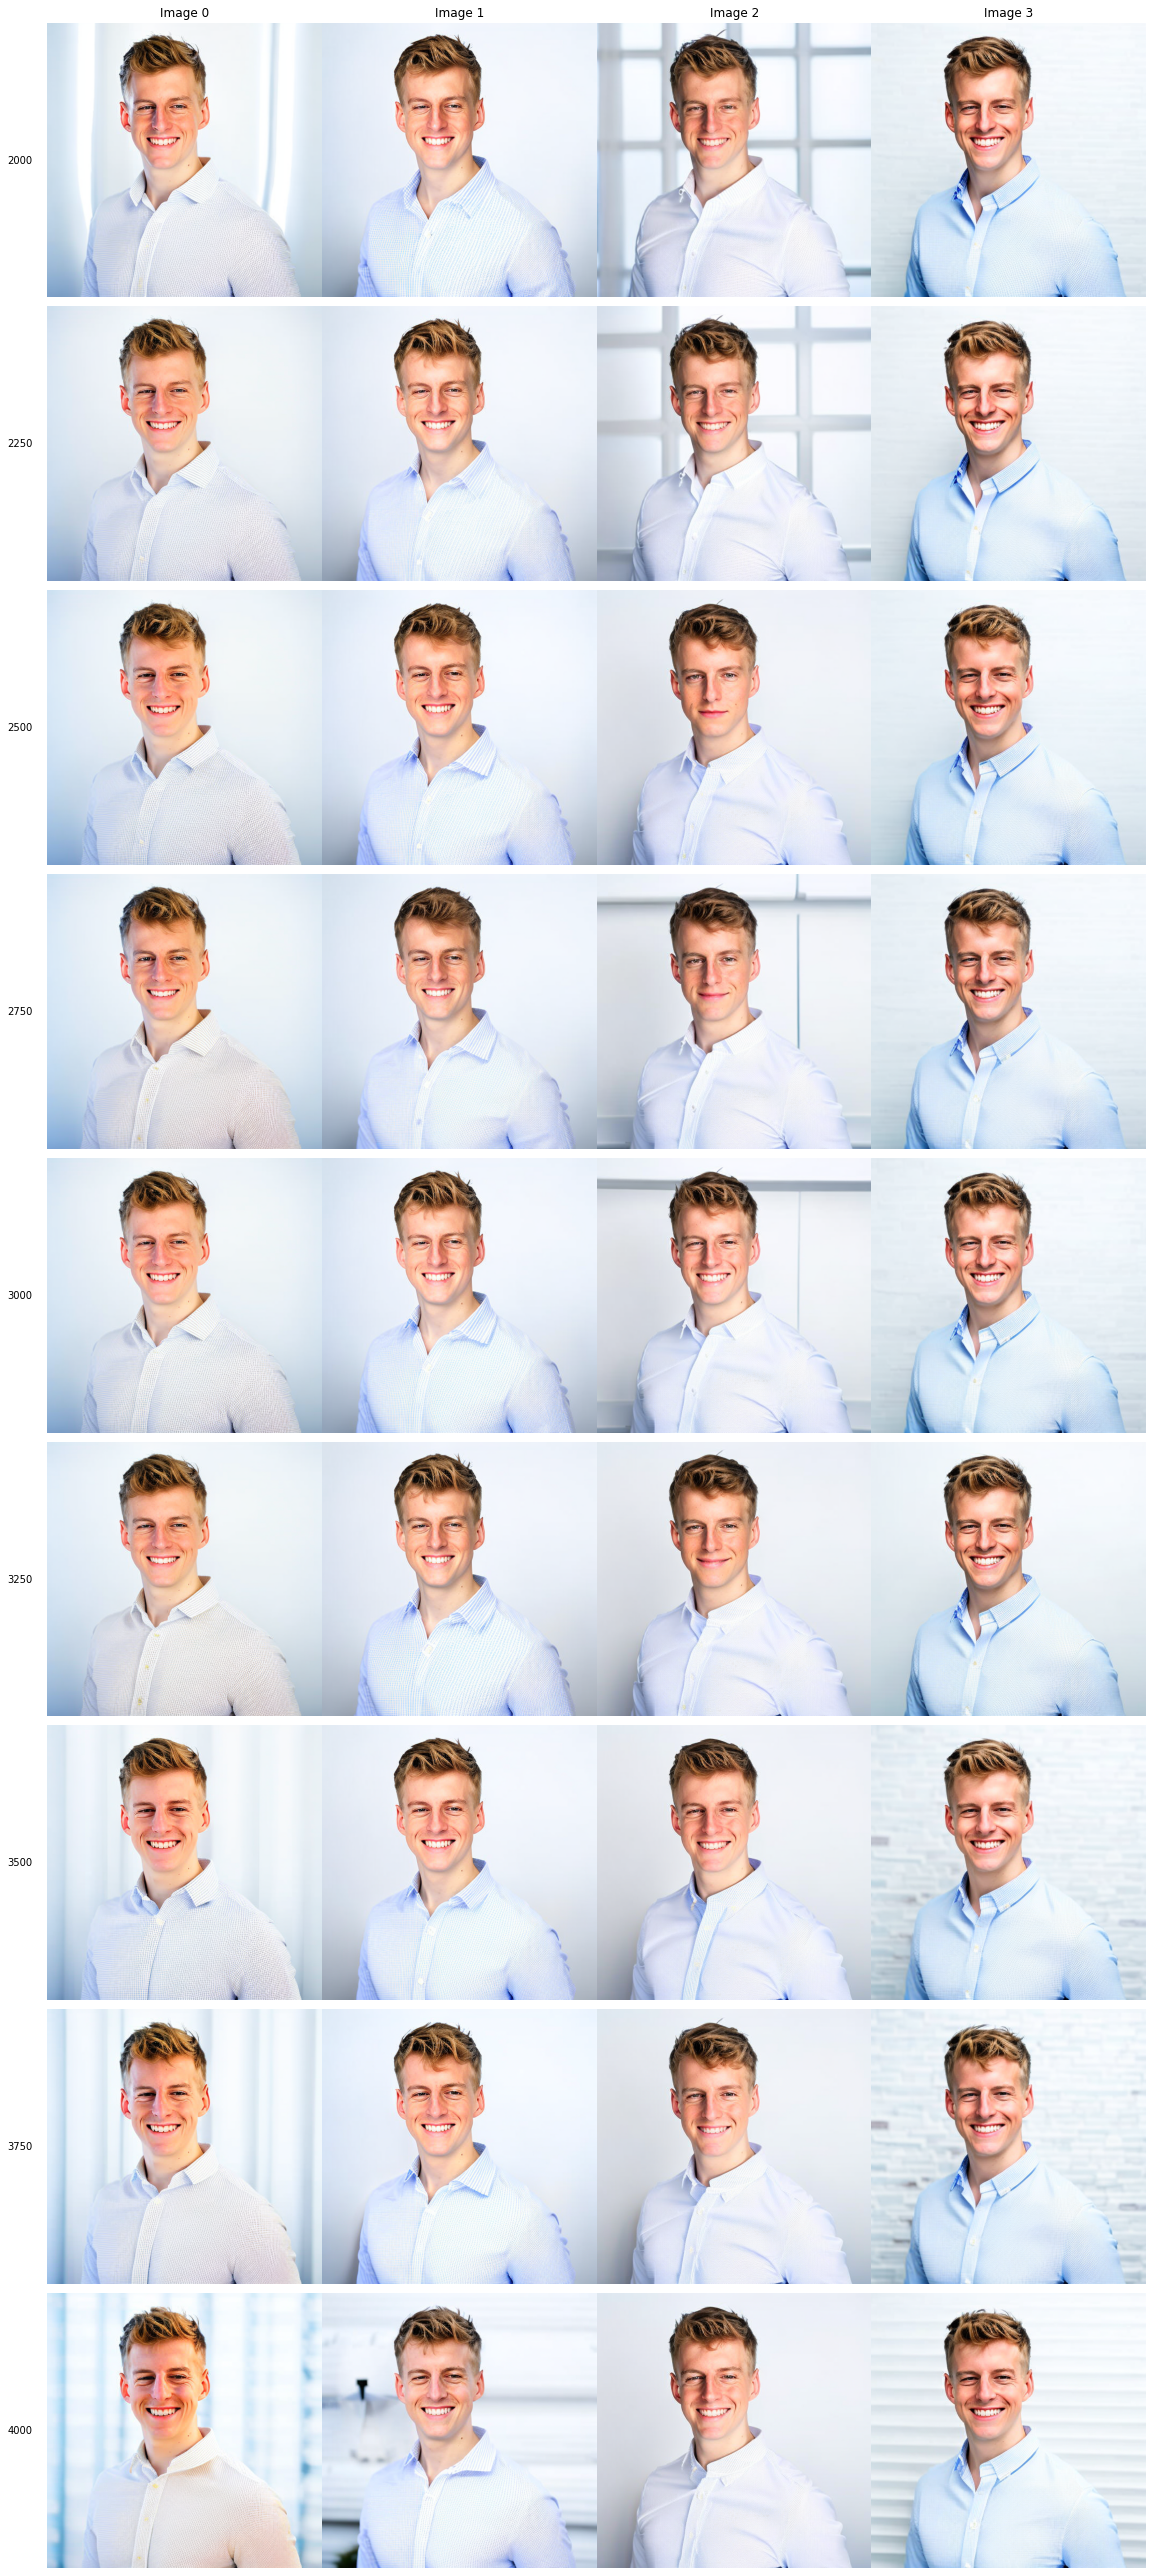

In [17]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)
wandb.log({"finetuning_results_overview": fig})

### Inference

In [29]:
# Util functions
from PIL import Image
PRECISION="fp16"
if PRECISION == "fp16":
    fp16 = True
else:
    fp16 = False

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [23]:
# Useful later when we actually use the depth2img model
DEPTH2IMG_DIR = "/content/inference/depth2img"
!mkdir $DEPTH2IMG_DIR

In [24]:
for filename in glob.glob(os.path.join("/content/drive/MyDrive/StableDiffusion/pictures_depth2img", '*.*')):
    shutil.copy(filename, DEPTH2IMG_DIR)

### Which weights should be loaded?

In [36]:
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, "3250")
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/train/3250


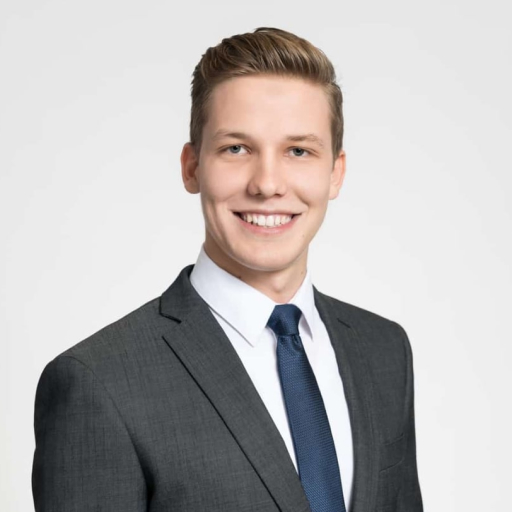

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionDepth2ImgPipeline and will be ignored.


  0%|          | 0/57 [00:00<?, ?it/s]

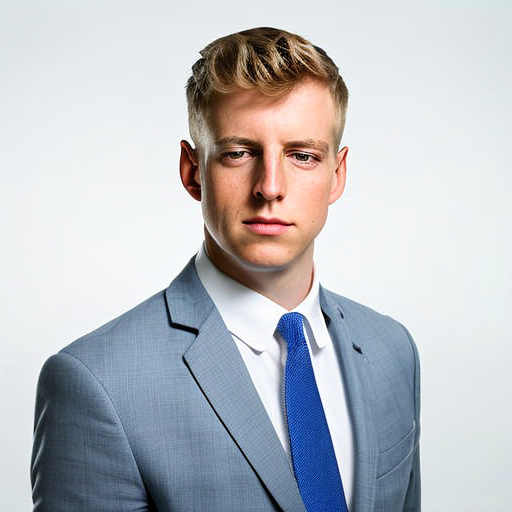

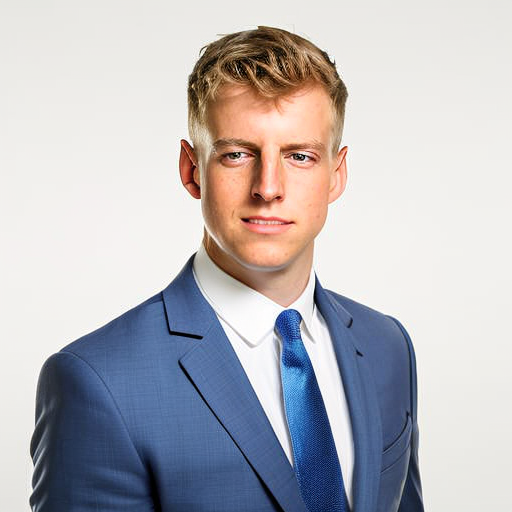

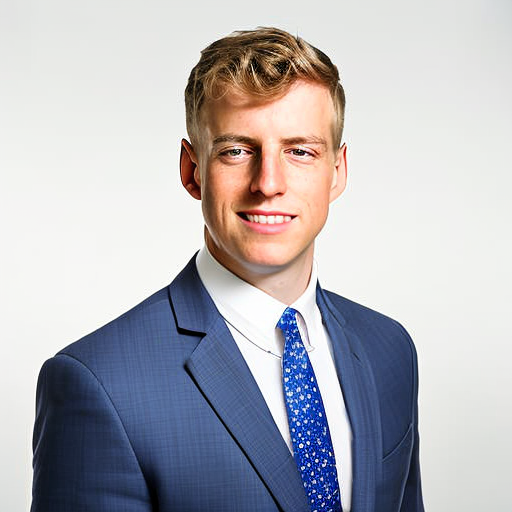

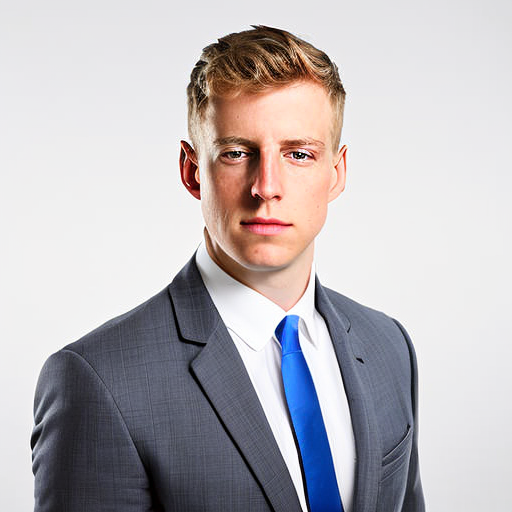

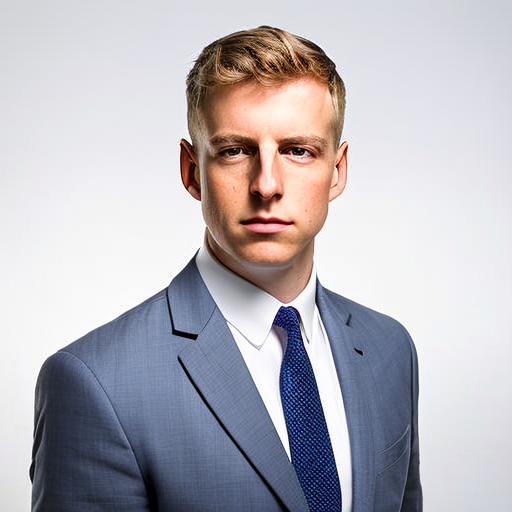

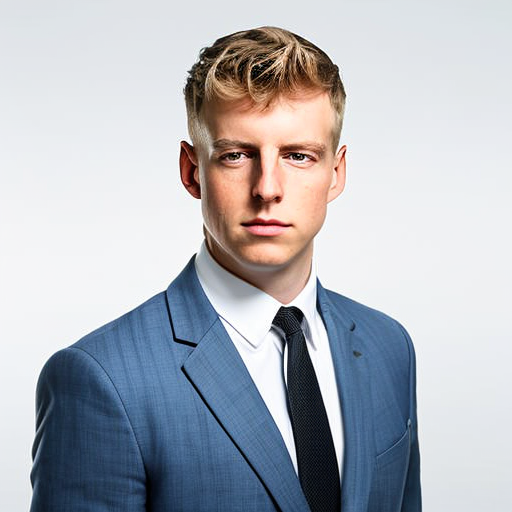

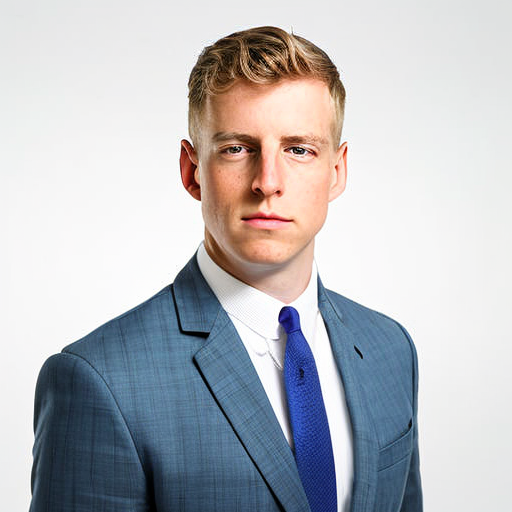

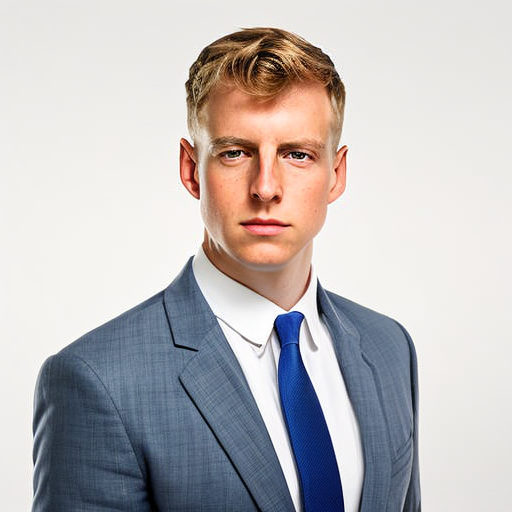

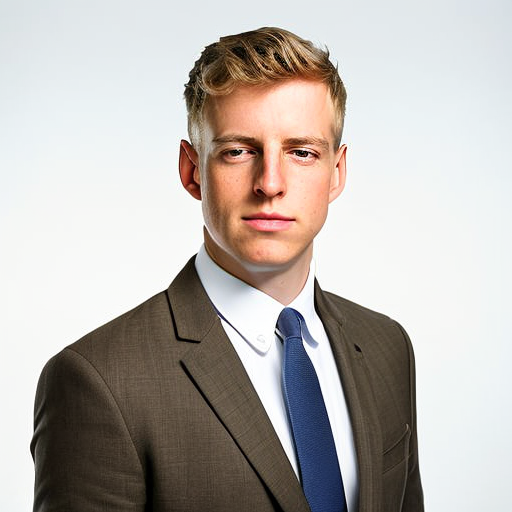

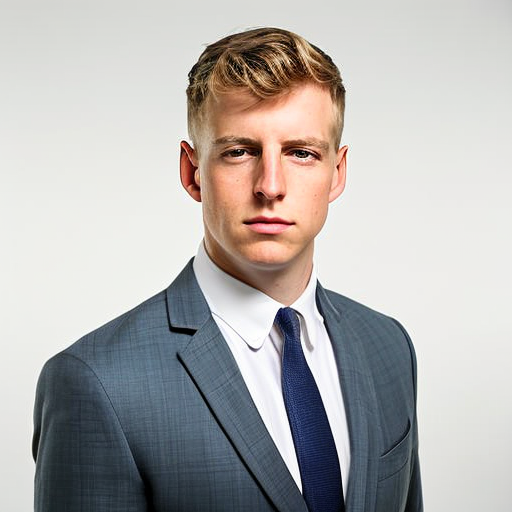

In [38]:
import torch
from torch import autocast
from diffusers import StableDiffusionDepth2ImgPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

from IPython.display import display
import requests
from PIL import Image


url = "https://ca.slack-edge.com/TUTJQ5RNV-U02P1ET637V-7d91d73a4fd4-512"
init_image = Image.open(requests.get(url, stream=True).raw)
init_image = Image.open("/content/inference/depth2img/Mann_blond_27.jpg")
display(init_image)
scheduler_euler = EulerDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_NAME,subfolder="scheduler")

# First for Euler
if fp16:
  pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(model_path, scheduler=scheduler_euler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(model_path, scheduler=scheduler_euler, safety_checker=None, torch_dtype=torch.float32).to("cuda")

# Then for DDIM
g_cuda = torch.Generator(device='cuda').manual_seed(52362)

prompt = "photo of of jseidenfuss, front view, closeup, centered frame, symmetric, studio lighting, clear and realistic face, uhd faces, pexels, 85mm, casual pose, 35mm film roll photo, hard light, detailed skin texture, masterpiece, sharp focus, pretty, lovely, adorable, attractive, hasselblad, candid street portrait"
negative_prompt = "blender, (smile), teeth, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white "
num_samples = 10
guidance_scale = 7
num_inference_steps = 70
height = 512
width = 512

images = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.825,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=g_cuda
).images

for image in images:
  display(image)

# Run over multiple parameters and generate a grid.
"""grids = []
for num_inference_steps in [50, 70, 90]:
  with autocast("cuda"), torch.inference_mode():
      images = pipe(
          prompt,
          height=height,
          width=width,
          negative_prompt=negative_prompt,
          num_images_per_prompt=num_samples,
          num_inference_steps=num_inference_steps,
          guidance_scale=guidance_scale,
          generator=g_cuda
      ).images
      grid = image_grid(images, 1, num_samples)
      grids.append(grid)
"""
del pipe

### Store model

In [39]:
artifact = wandb.Artifact('SD_D2I_2.0_2750_finetuned_jseidenfuss', type='model')
artifact.add_dir(os.path.join(OUTPUT_DIR, "2750"))
run.log_artifact(artifact)

wandb: Adding directory to artifact (/content/stable_diffusion_weights/train/2750)... Done. 19.8s


In [40]:
run.finish()

In [ ]:
exit()